In [12]:
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Annotated, Any, Dict
# import random
import gradio as gr
import uuid
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
# from langchain_community.utilities import GoogleSerperAPIWrapper

In [13]:
load_dotenv(override=True)

True

In [ ]:
class State(BaseModel):
    messages: Annotated[list[Any], add_messages]
    topic: str
    number_of_classes: int

In [15]:
graph_builder = StateGraph(State)

In [16]:
llm = ChatOpenAI(model="gpt-4o-mini")

def course_outline_generator(state: State) -> Dict[str, Any]:
    system_message = "You are a helpful educational assistant."
    user_message= f"""
    Please create a course outline on '{state.topic}' with {state.number_of_classes} classes.
    Format the response in markdown with class titles as headings and bullet points for key topics under each class.
    """

    # if state.first_run:
    #     messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    # else:
    #     messages = state.messages
    messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    messages += state.messages

    response = llm.invoke(messages)
    return {"messages": [response]}

graph_builder.add_node("generate_course_outline", course_outline_generator)

In [17]:
graph_builder.add_edge(START, "generate_course_outline")
graph_builder.add_edge("generate_course_outline", END)

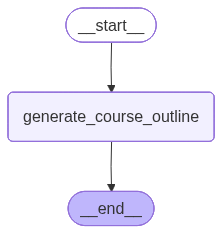

In [18]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

In [ ]:

async def process_message( message, topic, number_of_classes, history, thread):

    config = {"configurable": {"thread_id": thread}}

    # Only add user message if it's not empty
    if message and message.strip():
        messages = [{"role": "user", "content": message}]
    else:
        messages = []

    state = State(messages=messages, topic=topic, number_of_classes=number_of_classes)
    result = await graph.ainvoke(state, config=config)
    
    # Only show user message in chat history if it was actually provided
    if message and message.strip():
        user = {"role": "user", "content": message}
        reply = {"role": "assistant", "content": result["messages"][-1].content}
        return history + [user, reply]
    else:
        reply = {"role": "assistant", "content": result["messages"][-1].content}
        return history + [reply]

async def reset():
    return "", "", "", None, make_thread_id()

In [21]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as user_interface:
    gr.Markdown("## Course Creator Assistant")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="chatbot", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            topic_input = gr.Textbox(show_label=False, placeholder="Class topic (e.g., Python programming)")
        with gr.Row():
            number_of_classes = gr.Textbox(show_label=False, placeholder="Number of classes")
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your comment here...")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
        
    topic_input.submit(process_message, [message, topic_input, number_of_classes, chatbot, thread], [chatbot])
    number_of_classes.submit(process_message, [message, topic_input, number_of_classes, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, topic_input, number_of_classes, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, topic_input, number_of_classes, chatbot, thread])

    
user_interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
